# Perceptron Lab





In [656]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import Perceptron
import numpy as np

## 1. (40%) Correctly implement and submit your own code for the perceptron learning algorithm. 

### Code requirements
- Shuffle the data each epoch.
- A way to create a random train/test split. Write your own. In the future you can use the scikit-learn version if you want.
- Use Stochastic/On-line training updates: Iterate and update weights after each training instance (i.e. do not attempt batch updates)
- Implement a stopping criteria: when your model has trained for a number of epochs with no significant improvement in accuracy, stop training. Note that the weights/accuracy do not usually change monotonically.
- Use your perceptron to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident it is correct, run your perceptron on the Evaluation data with the same parameters, and include your final weights in your report PDF.

In [657]:
class PerceptronClassifier(BaseEstimator,ClassifierMixin):

    def __init__(self, lr=.1, shuffle=True, deterministic=True):
        """ 
            Initialize class with chosen hyperparameters.
        Args:
            lr (float): A learning rate / step size.
            shuffle: Whether to shuffle the training data each epoch. DO NOT 
            SHUFFLE for evaluation / debug datasets.
        """
        self.lr = lr
        self.shuffle = shuffle
        self.deterministic = deterministic
        self.epochs = 1

    def fit(self, X, y, initial_weights=None):
        """ 
            Fit the data; run the algorithm and adjust the weights to find a 
            good solution
        Args:
            X (array-like): A 2D numpy array with the training data, excluding
            targets
            y (array-like): A 2D numpy array with the training targets
            initial_weights (array-like): allows the user to provide initial 
            weights
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """

        finished = False
        rows, cols = X.shape
        epochs_same_accuracy = 0
        prev_score = 0
        # Add Bias column to X
        X = np.concatenate((X, np.column_stack(np.ones(rows)).T), axis=1)
        self.initial_weights = self.initialize_weights(cols + 1) if not initial_weights else initial_weights
        while not finished:
            # Shuffle if necessary
            if self.shuffle:
                X, y = self._shuffle_data(X, y)

            # Multiply each input by each weight and hold sum
            for idx, inputs in enumerate(X):
                target = y[idx]
                net = np.dot(inputs, self.initial_weights)
                if net <= 0:
                    # If net is <= 0, output is 0
                    # If output doesn't match target, update weights
                    if target != 0:
                        self._update_weights(inputs, target, output=0)
                else:
                    if target != 1:
                        self._update_weights(inputs, target, output=1)

            # Check the accuracy
            if self.deterministic:
               if self.epochs == 10:
                   finished = True
            else:
                # Check the accuracy
                score = self.score(X[:, :-1], y)
                if prev_score == score:
                    epochs_same_accuracy += 1
                if epochs_same_accuracy > 3:
                    finished = True
                if self.epochs > 100:
                    finished = True
                prev_score = score
            self.epochs += 1
        return self

    def predict(self, X):
        """ 
            Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding 
            targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        return [1 if i > 0 else 0 for i in np.dot(X, self.initial_weights[:-1])]

    def initialize_weights(self, n):
        """ Initialize weights for perceptron. Don't forget the bias!
        Returns:
        """
        return [0] * n

    def score(self, X, y, type='accuracy'):
        """ 
            Return accuracy of model on a given dataset. Must implement own 
            score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
            type (str): What type of score to return
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        num_datapoints, _ = X.shape
        num_correct = 0
        l2 = 0
        out = self.predict(X)
        # Loop through each target to get the L2 score
        for i, target in enumerate(y):
            # L2 formula: Summation(ti - zi) ** 2
            l2 += (target - out[i]) ** 2
            if target == out[i]:
                num_correct += 1

        if type.lower() == 'l2':
            return l2
        elif type.lower() == 'mse':
            # Divide the l2 score by the # of data points for the MSE score
            return l2 / num_datapoints
        elif type.lower() == 'rmse':
            # Take the square root of the MSE for the RMSE
            return (l2 / num_datapoints) ** (1/2)
        else:
            # Just return how accurate it was against the targets
            return num_correct / num_datapoints


    def _shuffle_data(self, X, y):
        """ 
            Shuffle the data! This _ prefix suggests that this method should 
            only be called internally.
            It might be easier to concatenate X & y and shuffle a single 2D 
            array, rather than shuffling X and y exactly the same way, 
            independently.
        """
        # Concatenate 2 arrays
        xy_concat = np.concatenate((X, np.column_stack(y).T), axis=1)
        # Shuffle the concatenated arrays
        np.random.shuffle(xy_concat)
        y = np.array([s for s in xy_concat[:, -1]])
        X = np.array(xy_concat[:, :-1])
        return X, y

    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return self.initial_weights

    def get_num_epochs(self):
        return self.epochs
    
    def _update_weights(self, inputs, target, output):
        w = self.initial_weights.copy()
        for idx, x in enumerate(inputs):
            w[idx] = self.lr * (target - output) * x

        self.initial_weights = np.add(self.initial_weights, w)


## 1.1 Debug 

Debug your model by running it on the [debug dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff)

Parameters:

Learning Rate = 0.1\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Initial Weights = All zeros

---

Expected Results

Accuray = [0.88]\
Final Weights = [-0.23  0.18 -0.1 ]

In [658]:
from scipy.io import arff
import pandas as pd

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff --output linsep2nonorigin.arff
perceptron = PerceptronClassifier(shuffle=False)

# Load debug data
data = arff.loadarff('linsep2nonorigin.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
# class_label = np_data[:, -1]
class_label = np.array([int(s.decode()) for s in np_data[:, -1]])
dataset = np.array(np_data[:, :-1])
# Train on debug data
perceptron.fit(dataset, class_label)
# Check weights
print(f'Accuracy = {perceptron.score(dataset, class_label)}')
print(f'Final Weights = {perceptron.get_weights()}')

Accuracy = 0.75
Final Weights = [-0.23  0.18 -0.1 ]


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   197  100   197    0     0   2073      0 --:--:-- --:--:-- --:--:--  2095


## 1.2 Evaluation

We will evaluate your model based on it's performance on the [evaluation dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff)

In [659]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff --output data_banknote_authentication.arff
perceptron = PerceptronClassifier(shuffle=False)

# Load evaluation data
data = arff.loadarff('data_banknote_authentication.arff')
df = pd.DataFrame(data[0])
np_data = np.array(df)
class_label = np.array([int(s.decode()) for s in np_data[:, -1]])
dataset = np.array(np_data[:, :-1])
# Train on evaluation data
perceptron.fit(dataset, class_label)
# Print weights
print(perceptron.get_weights())

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 46685  100 46685    0     0   367k      0 --:--:-- --:--:-- --:--:--  370k


[-3.80657242 -2.840821   -3.0719334  -1.4003906   4.9       ]


## 2. (10%) Create 2 datasets

- Both with 8 instances using 2 real valued inputs (ranging between -1 and 1) with 4 instances from each class. 
- One data set should be linearly separable and the other not.
- Graph each dataset

![Linearly Separable Data](https://raw.githubusercontent.com/rmorain/CS472-1/master/images/perceptron/linearly_separable.png)

![Not Linearly Separable](https://raw.githubusercontent.com/rmorain/CS472-1/master/images/perceptron/not_linearly_separable.png)

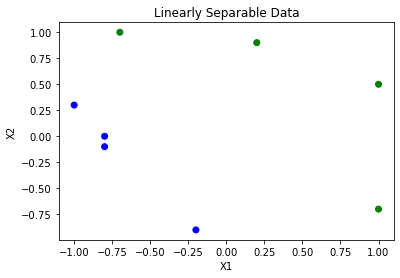

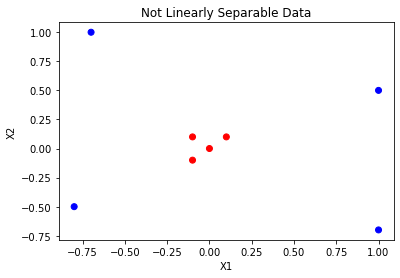

In [660]:
import matplotlib.pyplot as plt
import pandas as pd

# Create 2 datasets

# Dataset 1: Linearly Separable Data
d1 = [[.2, .9], [-.2, -.9], [-.8, -.1], [-1, .3], [1, .5], [1, -.7], [-.7, 1], [-.8, 0]]
class_labels1 = [0, 1, 1, 1, 0, 0, 0, 1]
colormap = np.array(['g', 'b'])
df1 = pd.DataFrame(d1, columns=['x1', 'x2'])
plt.title('Linearly Separable Data')
plt.xlabel('X1')
plt.ylabel('X2')
plt.scatter(df1.x1, df1.x2, c=colormap[class_labels1])
plt.show()

# Dataset 2: Not Linearly Separable Data
d2 = [[0, 0], [-.1, -.1], [.1, .1], [-.1, .1], [1, .5], [1, -.7], [-.7, 1], [-.8, -.5]]
class_labels2 = [1, 1, 1, 1, 0, 0, 0, 0]
colormap = np.array(['b', 'r'])
df2 = pd.DataFrame(d2, columns=['x1', 'x2'])
plt.title('Not Linearly Separable Data')
plt.xlabel('X1')
plt.ylabel('X2')
plt.scatter(df2.x1, df2.x2, c=colormap[class_labels2])
plt.show()


## 3. (10%) Train on both sets with your perceptron code.

- Use a couple different learning rates.


In [661]:
p1 = PerceptronClassifier(deterministic=False)
p1_shuffle = PerceptronClassifier(shuffle=True, deterministic=False)
p1_1 = PerceptronClassifier(lr=.3, shuffle=False, deterministic=False)
p1_2 = PerceptronClassifier(lr=.7, shuffle=False, deterministic=False)
p1_3 = PerceptronClassifier(lr=.9, shuffle=False, deterministic=False)

p2 = PerceptronClassifier(deterministic=False)
p2_shuffle = PerceptronClassifier(shuffle=True, deterministic=False)
p2_1 = PerceptronClassifier(lr=.3, shuffle=False, deterministic=False)
p2_2 = PerceptronClassifier(lr=.7, shuffle=False, deterministic=False)
p2_3 = PerceptronClassifier(lr=.9, shuffle=False, deterministic=False)
# Train on each dataset
# Training on dataset 1
dataset1 = np.array(d1)
t1 = np.array(class_labels1)
p1.fit(dataset1, t1)
p1_shuffle.fit(dataset1, t1)
p1_1.fit(dataset1, t1)
p1_2.fit(dataset1, t1)
p1_3.fit(dataset1, t1)
print(f'D1 Weights fit with lr = .1: {p1.get_weights()} after {p1.get_num_epochs()} epochs')
print(f'D1 Weights shuffle fit with lr = .1: {p1_shuffle.get_weights()} after {p1_shuffle.get_num_epochs()} epochs')
print(f'D1 Weights fit with lr = .3: {p1_1.get_weights()} after {p1_1.get_num_epochs()} epochs')
print(f'D1 Weights fit with lr = .7: {p1_2.get_weights()} after {p1_2.get_num_epochs()} epochs')
print(f'D1 Weights fit with lr = .9: {p1_3.get_weights()} after {p1_3.get_num_epochs()} epochs')


# Training on dataset 2
dataset2 = np.array(d2)
t2 = np.array(class_labels2)
p2.fit(dataset2, t2)
p2_shuffle.fit(dataset2, t2)
p2_1.fit(dataset2, t2)
p2_2.fit(dataset2, t2)
p2_3.fit(dataset2, t2)
print(f'D2 Weights fit with lr = .1: {p2.get_weights()} after {p2.get_num_epochs()} epochs')
print(f'D2 Weights shuffle fit with lr = .1: {p2_shuffle.get_weights()} after {p2_shuffle.get_num_epochs()} epochs')
print(f'D2 Weights fit with lr = .3: {p2_1.get_weights()} after {p2_1.get_num_epochs()} epochs' )
print(f'D2 Weights fit with lr = .7: {p2_2.get_weights()} after {p2_2.get_num_epochs()} epochs')
print(f'D2 Weights fit with lr = .9: {p2_3.get_weights()} after {p2_3.get_num_epochs()} epochs')

D1 Weights fit with lr = .1: [-0.13 -0.16  0.  ] after 6 epochs
D1 Weights shuffle fit with lr = .1: [-0.12 -0.14  0.  ] after 6 epochs
D1 Weights fit with lr = .3: [-0.36 -0.42  0.  ] after 6 epochs
D1 Weights fit with lr = .7: [-0.84 -0.98  0.  ] after 6 epochs
D1 Weights fit with lr = .9: [-1.08 -1.26  0.  ] after 6 epochs
D2 Weights fit with lr = .1: [ 0.03 -0.1   0.  ] after 7 epochs
D2 Weights shuffle fit with lr = .1: [-0.06 -0.03  0.  ] after 6 epochs
D2 Weights fit with lr = .3: [-0.27 -0.18 -0.6 ] after 21 epochs
D2 Weights fit with lr = .7: [-0.63 -0.42 -1.4 ] after 21 epochs
D2 Weights fit with lr = .9: [-0.27 -0.27 -1.8 ] after 12 epochs


Discuss the effect of learning rate, including how many epochs are completed before stopping. (For these cases, learning rate should have minimal effect, unlike with the Backpropagation lab.)


*Discuss learning rate here*
> For the Linearly Separable Data, altering the learning rate did not have a significant effect on how quickly it
> learned. For example, The number of epochs it took to solve seems to stay static at 6. (Though it took 7 epochs with
> the lr=.1.) For lr = .3, .7, and .9 it took 6 epochs to fit.
>
> For the Not Linearly Separable Data, I observed more interesting characteristics; for example, the epochs didn't stay
> as static as the Linearly Separable Data. With lr=.1 and .9, it took 12 epochs to finish but with lr = .3 and .7 it
> took 21 epochs.


## 4. (10%) Graph the instances and decision line for the two cases above (with LR=.1)
 
 - For all graphs always label the axes!

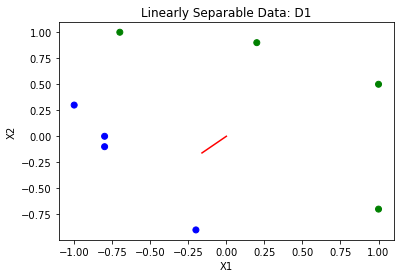

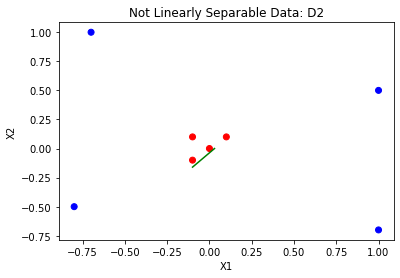

In [662]:
# Graph decision line
# Dataset 1: Linearly Separable Data
colormap = np.array(['g', 'b'])
plt.title('Linearly Separable Data: D1')
plt.xlabel('X1')
plt.ylabel('X2')
plt.scatter(df1.x1, df1.x2, c=colormap[class_labels1])
plt.plot([min(p1.get_weights()), max(p1.get_weights())], [min(p1.get_weights()), max(p1.get_weights())], 'k-', color = 'r')
plt.show()

# Dataset 2: Not Linearly Separable Data
colormap = np.array(['b', 'r'])
plt.title('Not Linearly Separable Data: D2')
plt.xlabel('X1')
plt.ylabel('X2')
plt.scatter(df2.x1, df2.x2, c=colormap[class_labels2])
plt.plot([min(p2.get_weights()), max(p2.get_weights())], [min(p1.get_weights()), max(p1.get_weights())], 'k-', color = 'g')
plt.show()

## 5. (20%) Use your perceptron code to learn this version of the [voting data set](https://raw.githubusercontent.com/rmorain/CS472-1/master/datasets/perceptron/voting-dataset.arff).

This particular task is an edited version of the standard voting set, where we have replaced all the “don’t know” values with the most common value for the particular attribute.  

### 5.1 Create a table that reports the final training and test set accuracy and the number of epochs for each trial.

- Try it five times with different random 70/30 splits. 
- Use your own code to randomize and make splits. 
- Report the average of these values for the 5 trials in the table.  

| Trial | Training Accuracy | Test accuracy | Number of epochs |
| --- | --- | --- | --- |
| 1 | .95 | .55 | 4 |
| Average each value by trial| | | 

*- As a rough sanity check, typical Perceptron test accuracies for the voting data set are 90%-98%.*


In [663]:
from tabulate import tabulate

!curl https://raw.githubusercontent.com/rmorain/CS472-1/master/datasets/perceptron/voting-dataset.arff --output voting-dataset.arff
perceptron = PerceptronClassifier(shuffle=True, deterministic=False)

# Load evaluation data
data = arff.loadarff('voting-dataset.arff')
df = pd.DataFrame(data[0])
df = df.apply(lambda x: x.str.decode('utf-8'))
df[df == "n"] = 0
df[df == "y"] = 1
df[df == "democrat"] = 0
df[df == "republican"] = 1
np_data = df.to_numpy()
class_labels = np.array(np_data[:, -1])
dataset = np.array(np_data[:, :-1])
perceptron.fit(dataset, class_labels)
perceptron.get_weights()
# Create table any way you like

table = [["1", perceptron.score(dataset, class_labels), perceptron.get_num_epochs()],
         ["2", ],
         ["3", ],
         ["4", ],
         ["5", ]]

print(tabulate(table))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 43825  100 43825    0     0   368k      0 --:--:-- --:--:-- --:--:--  372k


-  --------  ---
1  0.767896  102
2
3
4
5
-  --------  ---


### 5.2 By looking at the weights, explain what the model has learned and how the individual input features affect the result. Which specific features are most critical for the voting task, and which are least critical? 


*Explanation goes here*

### 5.3 Make a graph of the average misclassification rate vs epochs (0th – final epoch).

- Average the misclassification rate for the training set across your 5 trials (not across 5 epochs).


![Average Misclassification Rate](https://raw.githubusercontent.com/rmorain/CS472-1/master/images/perceptron/avg_misclassification_rate_vs_epochs.png)

In [664]:
# Graph here
    
def plot_misclassification(avg_misclassification_rate):
    """
        Plots the average misclassification rate
    Args:
        avg_misclassification_rate (array-like): A 1D array or list
    """
    plt.plot(np.arange(len(avg_misclassification_rate)), avg_misclassification_rate)
    plt.title("Average Misclassification Rate vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Misclassification Rate")
    plt.show()
    


## 6. (10%) Use the perceptron algorithm from the [scikit-learn toolkit](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) to learn the voting task above and also one other data set of your choice.

- Report and compare your results.
- Try out some of the hyper-parameters that scikit-learn makes available on your own perceptron.

In [665]:
# Load sklearn perceptron

# Train on voting dataset

*Report your comparison*

## 7. (Optional 5% extra credit) Use the perceptron rule to learn the [iris task](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff) or some other task with more than two possible output values. 

Note that the [iris data](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff) set has 3 output classes, and a perceptron node only has two possible outputs.  You could implement either of the two most common ways to deal with this. For testing you just execute the novel instance on each model and combine the overall results to see which output class wins.